### Main imports

In [6]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device.type)
print('Imports complete.')

Device: cuda
Imports complete.


### Import dataset

In [7]:
import os
import numpy
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = numpy.load(train_x_path)
train_y = numpy.load(train_y_path)
valid_x = numpy.load(valid_x_path)
valid_y = numpy.load(valid_y_path)
test_x = numpy.load(test_x_path)
test_y = numpy.load(test_y_path)
print("Data loaded successfully.")

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

train_x = train_x.reshape(-1, 3, 28, 28) 
valid_x = valid_x.reshape(-1, 3, 28, 28) 
test_x = test_x.reshape(-1, 3, 28, 28)

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

# convert NumPy arrays to PyTorch tensors - HAS BEEN CHANGED FOR THE ABOVE
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()

valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000


**View some of the test dataset**

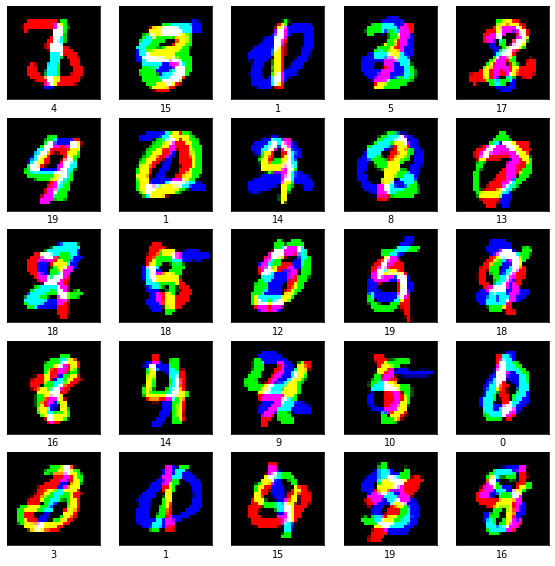

In [8]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = numpy.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

### Attempt 1 - 84% accuracy

In [9]:
class EnhancedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EnhancedCNN, self).__init__()
        # Increase initial channels for better feature extraction
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Add residual connections
        self.residual1 = nn.Conv2d(32, 64, kernel_size=1)
        self.residual2 = nn.Conv2d(64, 128, kernel_size=1)
        self.residual3 = nn.Conv2d(128, 256, kernel_size=1)
        
        # Dropout layers for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers with proper sizing
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 20)
        
        # Initialize weights using He initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # First convolutional block with residual
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        # Second block with residual connection
        identity = self.residual1(F.max_pool2d(identity, 2))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x + identity, 2)
        
        # Third block with residual
        identity = self.residual2(F.max_pool2d(x, 2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x + identity, 2)
        
        # Fourth block with residual
        identity = self.residual3(F.max_pool2d(x, 2))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.adaptive_pool(x + identity)
        
        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

N = EnhancedCNN().to(device)

print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

criterion = nn.CrossEntropyLoss()

optimiser = torch.optim.AdamW(N.parameters(), lr=0.001, weight_decay=0.01)
# optimiser = torch.optim.RMSprop(N.parameters(), lr=0.0018, alpha=0.90)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.225, patience=6)

plot_data = []
steps = 0
best_test_acc = 0.0


> Number of parameters 2697300


### Main training and testing loop - Attempt 1

In [10]:
# keep within our optimisation step budget
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = numpy.zeros(0)
    train_acc_arr = numpy.zeros(0)
    test_acc_arr = numpy.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        
        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = criterion(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = numpy.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = numpy.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # scheduler.step()

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = criterion(p,t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = numpy.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    avg_train_loss = numpy.mean(train_loss_arr)
    avg_train_acc = numpy.mean(train_acc_arr)
    avg_test_acc = numpy.mean(test_acc_arr)

    scheduler.step(avg_test_acc)

    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        torch.save(N.state_dict(), 'best_model.pth')

    # print your loss and accuracy data - include this in the final report
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

    # plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, numpy.array(train_acc_arr).mean(), numpy.array(train_acc_arr).std(), numpy.array(test_acc_arr).mean(), numpy.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

RuntimeError: Given groups=1, weight of size [64, 32, 1, 1], expected input[64, 3, 14, 14] to have 32 channels, but got 3 channels instead

## Inference on data

This is useful for analysis but is entirely optional

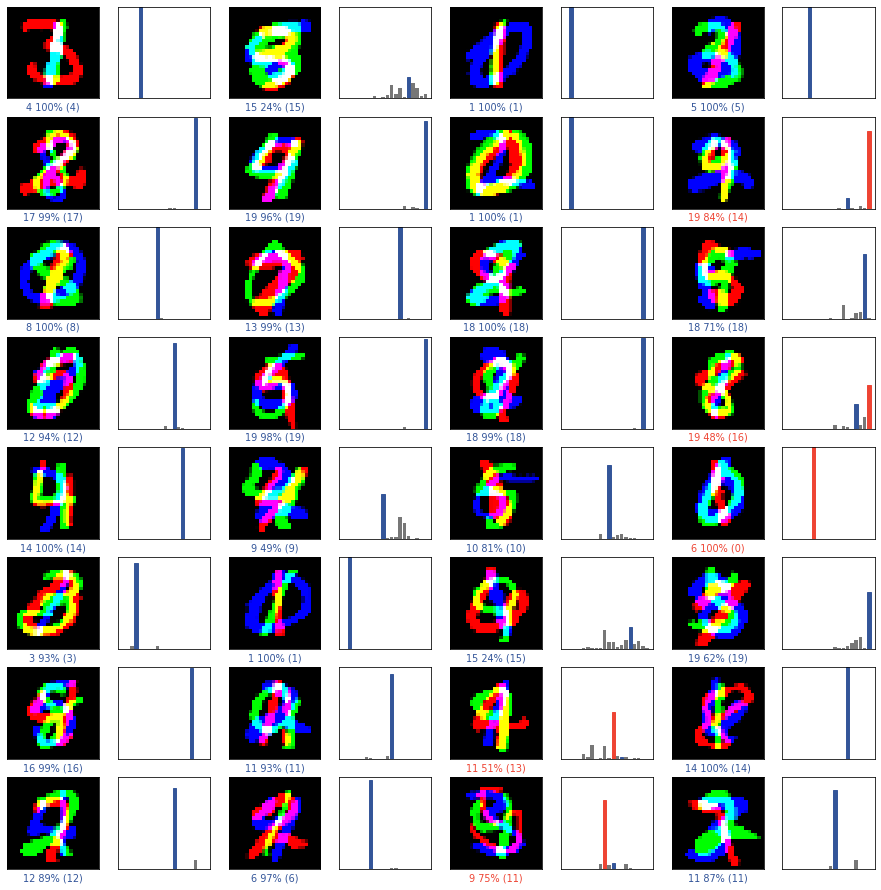

In [7]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = numpy.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = numpy.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = numpy.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*numpy.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = numpy.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())